<a href="https://colab.research.google.com/github/namtoptall/DataScience/blob/main/bitcoin_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dự báo chuỗi thời gian trong TensorFlow (BitPredict 💰📈)

Mục tiêu của notebook này là giúp bạn làm quen với việc làm việc với dữ liệu chuỗi thời gian (time series data).

Chúng ta sẽ xây dựng một loạt các mô hình nhằm cố gắng dự đoán giá Bitcoin.

Chào mừng bạn đến với Milestone Project 3, BitPredict 💰📈!

> 🔑 **Lưu ý:** ⚠️ Đây không phải là tư vấn tài chính, vì bạn sẽ thấy dự báo chuỗi thời gian về giá thị trường chứng khoán thực sự khá khủng khiếp.


In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
!pip install --upgrade tensorflow

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2024-08-01 13:03:53--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2024-08-01 13:03:53 (6.69 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [ ]:
# Import với pandas
import pandas as pd
# Phân tích cú pháp ngày và đặt cột date thành chỉ mục
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # phân tích cú pháp cột date (cho pandas biết cột 1 là ngày giờ)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [ ]:
df.info(), len(df)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


(None, 2787)

In [ ]:
# Chỉ cần closing price cho từng ngày
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head(10)

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866
2013-10-06,120.65533
2013-10-07,121.79500
2013-10-08,123.03300
2013-10-09,124.04900


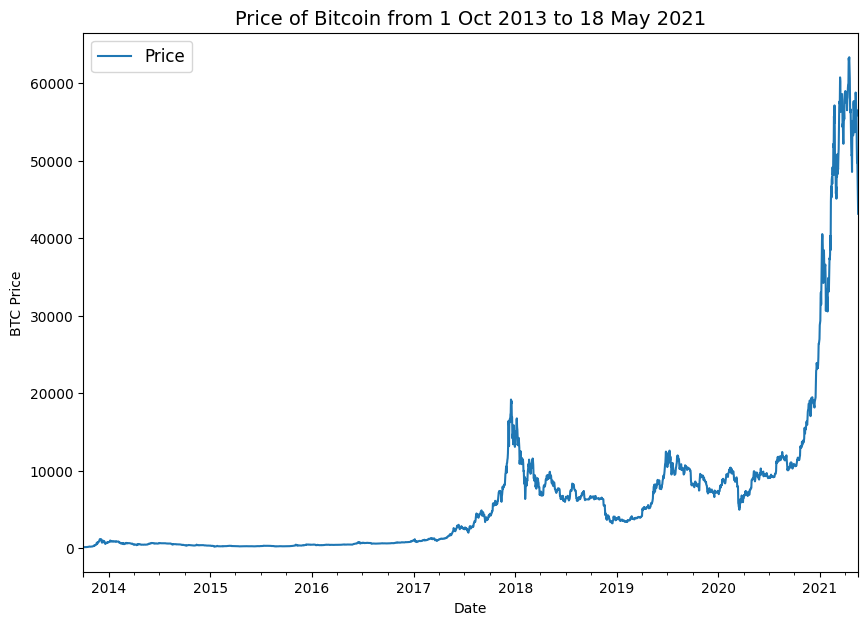

In [ ]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=14)
plt.legend(fontsize=12)

In [ ]:
import csv
from datetime import datetime

timesteps =  []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as csvfile:
  reader = csv.reader(csvfile, delimiter=",")
  next(reader)
  for line in reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # datetime string
    btc_price.append(float(line[2])) # float closing price
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

## Định dạng dữ liệu Phần 1: Tạo tập huấn luyện và kiểm tra cho dữ liệu chuỗi thời gian

### cách tạo tập huấn luyện và kiểm tra cho chuỗi thời gian (không dùng train_test_split nha)


In [ ]:
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [ ]:
# Tạo train/test split đúng cách cho dữ liệu chuỗi thời gian
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Tạo phân tách dữ liệu huấn luyện (mọi thứ trước khi phân tách)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Tạo phần tách dữ liệu kiểm tra (mọi thứ sau khi phân tách)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

In [ ]:
# Tạo một hàm vẽ biểu đồ dữ liệu chuỗi thời gian
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Vẽ biểu đồ các bước thời gian (một loạt các điểm trong thời gian) với các giá trị (một loạt các giá trị trên các bước thời gian).

  Tham số
  ---------
  timesteps : mảng của các bước thời gian
  values : mảng của các giá trị theo theo thời gian
  format : kiểu của biểu đồ, mặc định là "."
  start : nơi bắt đầu biểu đồ (đặt một giá trị sẽ lập chỉ mục từ start của timesteps & values)
  end : nơi kết thúc biểu đồ (đặt một giá trị sẽ lập chỉ mục từ end của timesteps & values)
  label : nhãn để hiển thị trên biểu đồ giá trị
  """
  # Vẽ biểu đồ các chuỗi
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # làm cho nhãn lớn hơn
  plt.grid(True)

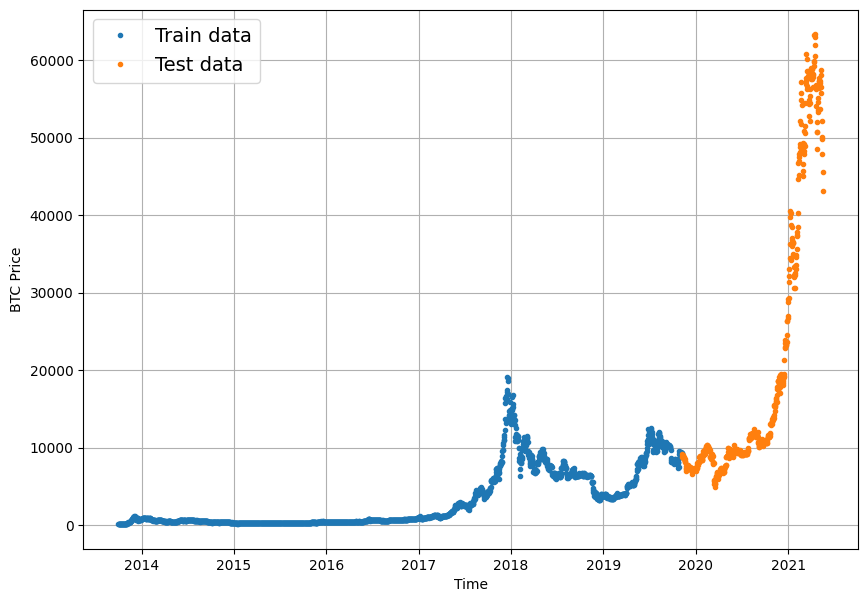

In [ ]:
# Hãy thử hàm vẽ biểu đồ
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Model 0: Naïve forecast (baseline)


In [ ]:
# create a naive forecast
naive_forecast = y_test[:-1] # exclude the last data point
naive_forecast[:10], naive_forecast[-10:] # Hiển thị 10 giá trị đầu và 10 giá trị cuối

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

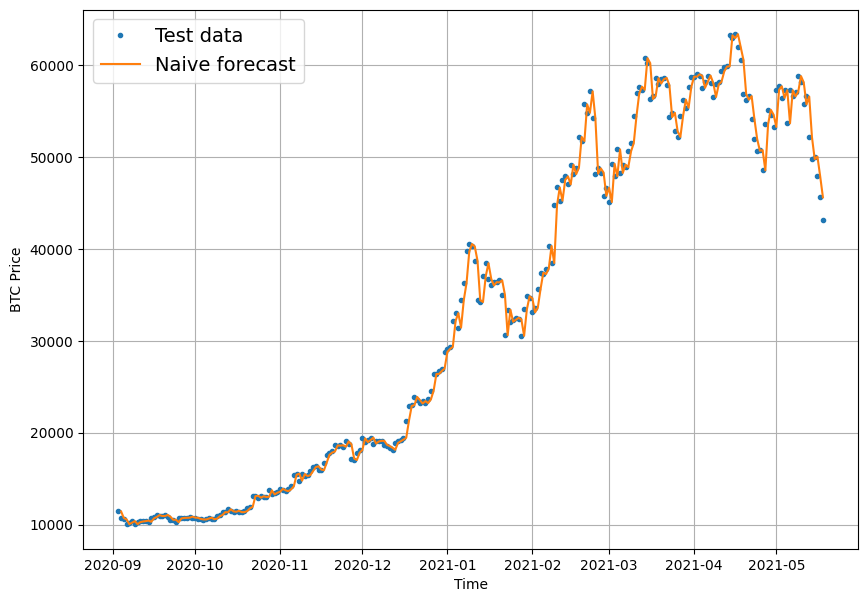

In [ ]:
plt.figure(figsize=(10, 7))
offset = 300 # offset các giá trị 300 bước thời gian
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");

In [ ]:
import tensorflow as tf
def mean_absolute_scaled_error(y_true,y_pred):
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))
  mae_naive_no_seasonality = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))
  return mae / mae_naive_no_seasonality

In [ ]:
def evaluate_preds(y_true, y_pred):
    # Ensure float32 type for calculations
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    # Initialize metrics
    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()
    mape_metric = tf.keras.metrics.MeanAbsolutePercentageError()

    # Update state of metrics
    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)
    mape_metric.update_state(y_true, y_pred)

    # Calculate metrics
    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    rmse = tf.sqrt(mse).numpy()
    mape = mape_metric.result().numpy()
    mase = mean_absolute_scaled_error(y_true, y_pred).numpy()

    return {
        "mae": mae,
        "mse": mse,
        "rmse": rmse,
        "mape": mape,
        "mase": mase
    }


In [ ]:
naive_results = evaluate_preds(y_true=y_test[1:],
                               y_pred=naive_forecast)
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

In [ ]:
# find the average bitcoin price
tf.reduce_mean(y_test).numpy()

20056.632963737226

## Những loại mô hình dự báo chuỗi thời gian khác có thể sử dụng cho các mô hình cơ sở và dự báo thực tế

Vì chúng ta có một mô hình naïve forecast cơ sở, nên hãy bắt đầu xây dựng các mô hình để thử và đánh bại nó.

Và vì khóa học này tập trung vào TensorFlow và DL, chúng ta sẽ sử dụng TensorFlow để xây dựng các mô hình DL nhằm thử và cải thiện các kết quả dự báo naïve forecasting.

Như vậy, có rất nhiều loại mô hình khác mà bạn có thể xem xét để xây dựng mô hình cơ sở/thực hiện dự báo.

Một số trong số chúng thậm chí có thể đánh bại các mô hình hoạt động tốt nhất của chúng ta trong notebook này, tuy nhiên, tôi sẽ để chúng cho phần đọc thêm.

| **Tên thư viện/Mô hình** | **Nguồn** |
| ----- | ----- |
| Moving average | https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/ |
| ARIMA (Autoregression Integrated Moving Average) | https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/ |
| sktime (Scikit-Learn for time series) | https://github.com/alan-turing-institute/sktime |
| TensorFlow Decision Forests (random forest, gradient boosting trees) | https://www.tensorflow.org/decision_forests |
| Facebook Kats (purpose-built forecasting and time series analysis library by Facebook) | https://github.com/facebookresearch/Kats |
| LinkedIn Greykite (flexible, intuitive and fast forecasts) | https://github.com/linkedin/greykite |

In [ ]:
HORIZON = 1
WINDOW_SIZE = 7

In [ ]:
def get_labelled_windows(x,horizon=1):
  return x[:, :-horizon], x[:, -horizon:]

In [ ]:
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8)+1,axis=0), horizon=HORIZON)
print(f"Window : {tf.squeeze(test_window).numpy()} -> Label : {tf.squeeze(test_label).numpy()}")

Window : [1 2 3 4 5 6 7] -> Label : 8


In [ ]:
import numpy as np
def make_windows(x, window_size=7, horizon=1):
  # create a window with specific window_size
  window_step = np.expand_dims(np.arange(window_size+horizon), axis =0)
  # create 2d layer with window steps
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # tạo mảng 2D có các window với window_size
  # create a window indexing
  windowed_araay = x[window_indexes]
  # create windows and labels
  windows, labels = get_labelled_windows(windowed_araay, horizon=horizon)
  return windows, labels

In [ ]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
print(len(full_windows), len(full_labels))
full_windows[:3], full_labels[:3]

2780 2780


(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116]]))

In [ ]:
# Xem 3 window/nhãn đầu tiên
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [ ]:
def make_train_test_splits(windows, labels, test_split=0.2):
  split_size = int(len(windows) * (1-test_split)) # 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [ ]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]),
 array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [ ]:
# Kiểm tra xem có giống nhau không (tính cả horizon/window size)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

### create model checkpoint

In [ ]:
import os

# Tạo một hàm lập trình ModelCheckpoint callback với filename cụ thể
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # tạo filepath để lưu mô hình
                                            verbose=0, # chỉ xuất một lượng văn bản hạn chế
                                            save_best_only=True) # chỉ lưu mô hình tốt nhất vào file

## Model 1: Dense model (window = 7, horizon = 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON, activation="linear")
], name="model_1_dense.keras")
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"])
model_1.summary()

Model: "model_1_dense.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model_1.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            callbacks=[create_model_checkpoint(model_name=model_1.name)])

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


In [ ]:
# Đánh giá mô hình trên dữ liệu kiểm tra
model_1.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 301.9391 - mae: 301.9391  


[601.4089965820312, 601.4089965820312]

In [ ]:
def make_preds(model,input_data):
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # trả về mảng 1D của các dự đoán

In [ ]:
model_1_preds = make_preds(model_1,test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


(556,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8731.428, 8672.732, 8950.134, 8664.316, 8634.872, 8646.551,
        8581.146, 8418.9  , 8360.4  , 8439.037], dtype=float32)>)

In [ ]:
# Đánh giá preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), # giảm xuống shape phù hợp
                                 y_pred=model_1_preds)
model_1_results

{'mae': 601.40894,
 'mse': 1219861.5,
 'rmse': 1104.4734,
 'mape': 2.728049,
 'mase': 1.0565089}

In [ ]:
naive_results

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.5165248,
 'mase': 0.99957}

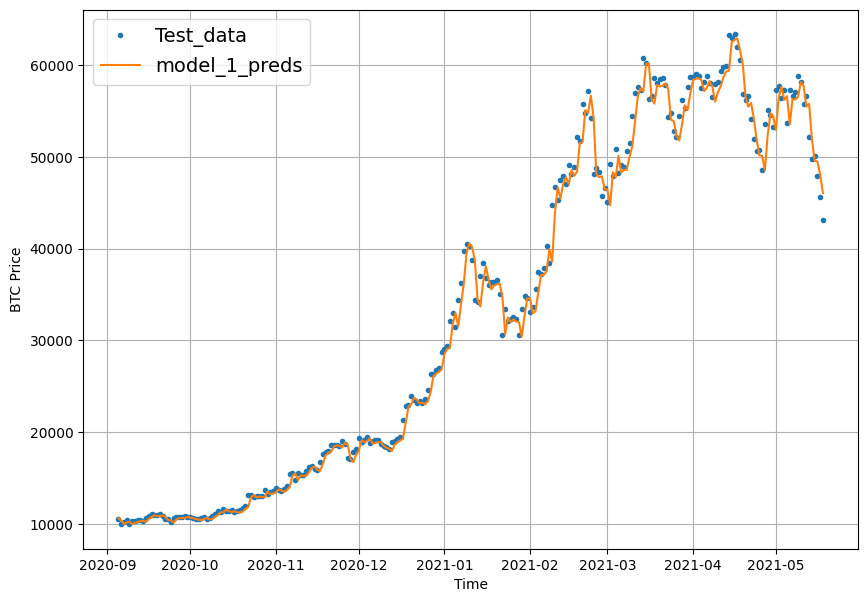

In [ ]:
offset = 300
plt.figure(figsize=(10, 7))
# Tính toán test_window offset và lập chỉ mục vào test_labels để đảm bảo vẽ đúng
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_1_preds, start=offset, format="-", label="model_1_preds")

## Model 2: Dense (window = 30, horizon = 1)


In [ ]:
HORIZON = 1 # dự đoán từng bước một
WINDOW_SIZE = 30 # sử dụng 30 bước thời gian trong quá khứ
# Tạo dữ liệu dạng window với horizon/window size thích hợp
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [ ]:
# Tạo train và test window
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [ ]:
tf.random.set_seed(42)

# Tạo mô hình (cùng một mô hình với model 1 nhưng dữ liệu đầu vào sẽ khác)
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON) # cần dự đoán horizon, số bước thời gian trong tương lai
], name="model_2_dense.keras")

model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [ ]:
model_2.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 314.0994 


618.471435546875

In [ ]:
model_2_preds = make_preds(model_2, test_windows)
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


{'mae': 618.4715,
 'mse': 1288695.4,
 'rmse': 1135.2072,
 'mape': 2.7816465,
 'mase': 1.0810941}

## Model 3: Dense (window = 30, horizon = 7)


In [ ]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows, labels=full_labels, test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [ ]:
tf.random.set_seed(42)

# Tạo mô hình (giống như model_1, trừ việc kích thước đầu vào dữ liệu khác)
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
], name="model_3_dense.keras")

model_3.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [ ]:
model_3.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 646.5337


1274.3350830078125

In [ ]:
# Các dự đoán sẽ có 7 bước cùng một lúc (đây là HORIZON size)
model_3_preds = make_preds(model_3,
                           input_data=test_windows)
model_3_preds[:5]

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[9373.355 , 9359.482 , 9290.101 , 9397.257 , 9604.234 , 9330.235 ,
        8932.82  ],
       [9022.763 , 9021.276 , 9131.264 , 8972.997 , 9317.269 , 9097.14  ,
        8727.081 ],
       [8776.905 , 8812.115 , 8894.592 , 8703.08  , 8777.798 , 9005.252 ,
        8588.235 ],
       [8939.395 , 8942.826 , 9100.377 , 8860.419 , 8837.898 , 9345.791 ,
        8834.174 ],
       [9055.1045, 9045.365 , 9074.571 , 8935.194 , 8833.36  , 9295.381 ,
        8732.07  ]], dtype=float32)>

In [ ]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1274.3351,
 'mse': 5550462.5,
 'rmse': 2355.942,
 'mape': 5.7767625,
 'mase': 2.2676077}

## Model 4: Conv1D

In [ ]:
HORIZON = 1 # dự đoán ngày tiếp theo
WINDOW_SIZE = 7 # sử dụng giá trị dữ liệu của tuần trước
# Tạo tập dữ liệu ở dạng window
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
# Tạo train/test split
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [ ]:
# Kiểm tra shape của mẫu dữ liệu
train_windows[0].shape # trả về (WINDOW_SIZE, )

(7,)

In [ ]:
# Trước khi truyền dữ liệu sang Conv1D layer, chúng ta phải reshape lại dữ liệu để đảm bảo nó hoạt động
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # thêm 1 dimension cho các bước thời gian
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [ ]:
tf.random.set_seed(42)

# Tạo mô hình
model_4 = tf.keras.Sequential([
  # Tạo Lambda layer để reshape đầu vào, nếu không có layer này, mô hình sẽ bị lỗi
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # thay đổi kích thước đầu vào để điều chỉnh window size/yêu cầu đầu vào Conv1D 3D
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D.keras")

# Biên dịch mô hình
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Khớp mô hình
model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

In [ ]:
model_4.summary()

Model: "model_4_conv1D.keras"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_1 (Lambda)                    │ (None, 1, 7)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 1, 128)              │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1, 1)                │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,213 (55.52 KB)

 Trainable params: 4,737 (18.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,476 (37.02 KB)

In [ ]:
# Đưa ra dự đoán
model_4_preds = make_preds(model_4, test_windows)
# Đánh giá dự đoán
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


{'mae': 576.9309,
 'mse': 1197520.0,
 'rmse': 1094.3126,
 'mape': 2.6040487,
 'mase': 1.0135078}

## Model 5: RNN (LSTM)

In [ ]:
tf.random.set_seed(42)
inputs = layers.Input(shape=(7,))
x = layers.Lambda(lambda x: tf.expand_dims(x,axis=1))(inputs)
x = layers.LSTM(128)(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs,outputs,name="model_5_lstm.keras")
model_5.compile(loss="mae",
              optimizer=tf.keras.optimizers.Adam())
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows,test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [ ]:
model_5.evaluate(test_windows, test_labels)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11207.7686


20016.734375

In [ ]:
model_5_preds = make_preds(model_5, test_windows)
# Đánh giá model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


{'mae': 20016.736,
 'mse': 707866400.0,
 'rmse': 26605.758,
 'mape': 99.33206,
 'mase': 35.16386}

## Tạo chuỗi thời gian đa biến

Cho đến giờ, tất cả các mô hình của chúng ta hầu như không theo kịp naïve forecast.

Và cho đến nay, tất cả chúng đều được huấn luyện trên một biến duy nhất (còn gọi là chuỗi thời gian đơn biến): giá lịch sử của Bitcoin.

Nếu việc dự đoán giá Bitcoin bằng cách sử dụng giá Bitcoin không hoạt động tốt, thì có thể việc cung cấp thêm thông tin cho mô hình của chúng ta sẽ hữu ích.

Thêm thông tin là một thuật ngữ mơ hồ vì chúng ta thực sự có thể cung cấp hầu hết mọi thứ cho (các) mô hình của mình và chúng vẫn sẽ cố gắng tìm ra các mẫu.

Ví dụ: chúng ta có thể sử dụng giá lịch sử của Bitcoin cũng như bất kỳ ai có tên [Daniel Bourke](https://twitter.com/mrdbourke) đã Tweet vào ngày đó để dự đoán giá tương lai của Bitcoin.

Nhưng điều này có giúp ích gì không?

Có thể là không.

Sẽ tốt hơn nếu chúng ta truyền cho mô hình của mình thứ gì đó liên quan đến Bitcoin (một lần nữa, điều này khá khó hiểu, vì trong một hệ thống mở như thị trường, bạn có thể thấy rằng mọi thứ đều có liên quan).

Điều này sẽ khác nhau đối với hầu hết mọi chuỗi thời gian bạn làm việc nhưng trong trường hợp này, chúng ta có thể thử xem liệu [Bitcoin block reward size](https://www.investopedia.com/terms/b/block-reward.asp) có bổ sung bất kỳ sức mạnh dự đoán nào cho (các) mô hình của chúng ta hay không.

Bitcoin block reward size là gì?

Bitcoin block reward size là số Bitcoin mà một người nào đó nhận được từ việc đào một khối Bitcoin.

Khi mới thành lập, Bitcoin block reward size là 50.

Nhưng cứ sau bốn năm hoặc lâu hơn, Bitcoin block reward lại giảm đi một nửa.

Ví dụ: block reward size từ 50 (bắt đầu từ 1/2009) giảm xuống còn thành 25 vào ngày 28/11/2012.

Hãy mã hóa thông tin này thành dữ liệu chuỗi thời gian và xem liệu nó có giúp ích cho chất lượng của mô hình hay không.

> 🔑 **Lưu ý:** Việc thêm một đặc trưng bổ sung vào tập dữ liệu như Bitcoin block reward size sẽ biến dữ liệu của chúng ta từ **đơn biến** (chỉ giá lịch sử của Bitcoin) thành **đa biến** (giá Bitcoin cũng như block reward size).

In [ ]:
# Hãy tạo chuỗi thời gian đa biến
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [ ]:
# Các giá trị block reward
block_reward_1 = 50 # 3 January 2009 (2009-01-03) - block reward này không có trong tập dữ liệu của chúng ra (nó bắt đầu từ 01/10/2013)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020

# Block reward dates (dạng datetime của các date stamp ở trên)
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")

In [ ]:
# Lấy chỉ mục date cho thời gian thêm các block date khác nhau
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2414)

In [ ]:
# Thêm cột block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Thiết lập giá trị của cột block_reward (đó là cột cuối cùng, do đó lập chỉ mục -1 trên iloc)
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


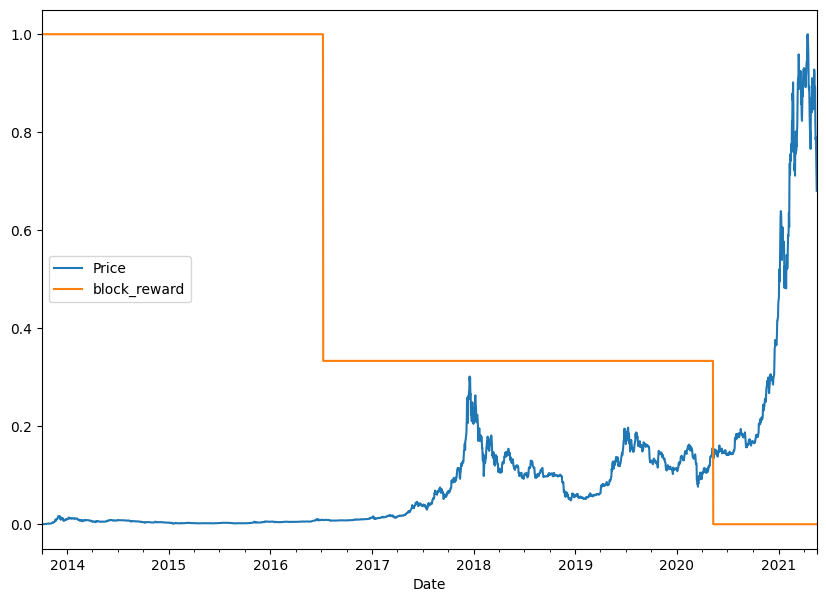

In [ ]:
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));

In [ ]:
# Thiết lập siêu tham số cho tập dữ liệu
HORIZON = 1
WINDOW_SIZE = 7
# Tạo bản sao dữ liệu lịch sử Bitcoin với đặc trưng block reward
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Thêm các cột có window
for i in range(WINDOW_SIZE): # Dịch chuyển giá trị cho mỗi bước trong WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


In [ ]:
# Hãy tạo X & y, xóa NaN và chuyển đổi thành float32 để ngăn lỗi TensorFlow
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [ ]:
# Tạo các tập huấn luyện và kiểm tra
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (chuỗi thời gian đa biến)

In [ ]:
tf.random.set_seed(42)

# Tạo mô hình chuỗi thời gian đa biến
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"), # thêm một layer bổ sung ở đây sẽ đánh bại naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate.keras")

# Biên dịch
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Khớp
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [ ]:
model_6.evaluate(X_test, y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 285.1475 


570.4495239257812

In [ ]:
model_6_preds = tf.squeeze(model_6.predict(X_test))
# Đánh giá preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


{'mae': 570.4495,
 'mse': 1173186.0,
 'rmse': 1083.1371,
 'mape': 2.5506148,
 'mase': 1.0021218}

## Model 7: Thuật toán N-BEATS


In [ ]:
# Tạo layer NBeatsBlock tùy chỉnh
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self, # hàm tạo lấy tất cả các siêu tham số cho layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # đối số **kwargs quản lý tất cả các đối số cho parent class (input_shape, trainable, name)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block chứa stack của 4 layer được kết nối đầy đủ, mỗi layer có kích hoạt ReLU
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    # Đầu ra của block là theta layer với kích hoạt tuyến tính
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs): # phương thức call là những gì sẽ chạy khi layer được gọi
    x = inputs
    for layer in self.hidden: # chuyển đầu vào qua mỗi layer ẩn
      x = layer(x)
    theta = self.theta_layer(x)
    # Xuất ra backcast và dự báo từ theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

In [ ]:
# Thiết lập NBeatsBlock layer giả để biểu diễn đầu vào và đầu ra
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [ ]:
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # shape đầu vào cho mô hình phải phản ánh các yêu cầu đầu vào của Dense layer (ndim=2)
# Truyền đầu vào giả cho NBeatsBlock layer giả
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# Đây là các đầu ra kích hoạt của theta layer (chúng sẽ ngẫu nhiên do không có huấn luyện mô hình)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.38508847  0.3228371   0.24189569  0.32218805 -0.5472059  -0.0843604
  0.03384594]
Forecast: -0.0972827672958374


In [ ]:
HORIZON = 1 # dự đoán về tương lai
WINDOW_SIZE = 7 # xem xét quá khứ
# Tạo đầu vào dữ liệu NBEATS (NBEATS hoạt động với chuỗi thời gian đơn biến)
bitcoin_prices.head()

# Thêm cột ở dạng window
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [ ]:
# Tạo các đặc trưng và nhãn
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Tạo các tập huấn luyện và kiểm tra
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [ ]:
# 1. Biến mảng huấn luyện và kiểm tra thành tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Kết hợp các đặc trưng & nhãn
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch và prefetch cho chất lượng tối ưu
BATCH_SIZE = 1024 # từ Appendix D trong tài liệu N-BEATS
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

In [ ]:
# Giá trị từ tài liệu N-BEATS: Hình 1 và Bảng 18/Phụ lục D
N_EPOCHS = 5000 # được gọi là "Iterations" trong Bảng 18
N_NEURONS = 512 # được gọi là "Width" trong Bảng 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # được gọi là "Lookback" trong Bảng 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

In [ ]:
# Tạo các tensor
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Trừ
subtracted = layers.subtract([tensor_1, tensor_2])

# Cộng
added = layers.add([tensor_1, tensor_2])

print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

### Xây dựng, biên dịch và khớp thuật toán N-BEATS

In [ ]:
 %%time

tf.random.set_seed(42)

# 1. Thiết lập N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Tạo input cho các stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Tạo đầu vào backcast và forecast ban đầu (trong tài liệu, dự đoán ngược được gọi là residual)
backcast, forecast = nbeats_block_layer(stack_input)
# Thêm liên kết subtraction residual: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00")

# 4. Tạo các stack chứa block
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Sử dụng NBeatsBlock để tính toán backcast cũng như block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # truyền nó trong residual (backcast)

  # 6. Tạo double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}")
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Kết hợp stack model với nhau
model_7 = tf.keras.Model(inputs=stack_input,
                         outputs=forecast,
                         name="model_7_N-BEATS")

# 8. Biên dịch với MAE loss và Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Khớp mô hình với EarlyStopping và ReduceLROnPlateau callback
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # ngăn cản lượng lớn kết quả huấn luyện
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # lưu mô hình mỗi epoch tiêu tốn quá nhiều thời gian
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])


Epoch 254: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 354: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 1h 7min 44s, sys: 1min 26s, total: 1h 9min 10s
Wall time: 44min 6s


In [ ]:
model_7.evaluate(test_dataset)

In [ ]:
# Đưa ra dự đoán với mô hình N-BEATS
model_7_preds = make_preds(model_7, test_dataset)
# Đánh giá dự đoán mô hình N-BEATS
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results